# SWA-EAS Data Products

<a id='Contents'></a>

## Contents

### 1. [Introduction](#Introduction)
### 2. [Data access](#Data_access)
### 3. [Raw data products](#Raw_data_products)
### 4. [Science data products](#Science_data_products)
### 5. [High level data products](#Higher_level_data_products)
### 6. [Further reading](#Further_reading)

<a id='Introduction'></a>

## 1. Introduction

**SWA-EAS** = Solar Wind Analyser - Electron Analyser System
<br>
![EAS photo](img/eas_photo.jpeg)
<div align="center"> SWA-EAS flight model </div>

**Sensor profile**

Objective: Resolve full 3D velocity space distributions of solar wind electrons with high cadence.

Design: Two orthogonal top-hat electrostatic analysers (EAS1 & EAS2) connected to a control electronics box.

Specification:
- Energy range = 1 eV-5 keV
- Cadence = 1 s (3D VDF) or 0.125 s (2D pitch angle)
- Field of view = Full 4$\pi$ steradian (in principle)

**Modes of data acquisition**

There are three key modes of EAS data acquisition:
- NM3D = Normal Mode 3D
- BM = Burst Mode
- TM = Trigger Mode (not yet available on Solar Orbiter archive)

NM3D: The standard mode for continuous operation. Generates a 1 s full velocity distribution function (VDF) every 10, 100 or 400 s (dependent on telemetry constraints).
<br>

BM: A special mode for periodic operation (typically once or twice per day). Generates a 0.125 s pitch angle distribution for 5 or 10 mins.
<br>

TM: A special mode for opportunistic operation (when there is a sudden change to the solar wind or the interplanetary magnetic field). Generates a 1 s full VDF every 1 s for 5 mins.

**Reference frames**

There are four key reference frames to be aware of when handling EAS data:
- EAS1 science frame = geometry relative to EAS1 sensor head
- EAS2 science frame = geometry relative to EAS2 sensor head
- Instrument frame = geometry relative to EAS sensor box
- S/C frame = geometry relative to Solar Orbiter spacecraft
<br>
<img src='img/eas_reference_frames.jpeg' width="350"/>
<div align="center"> SWA-EAS references frames </div>
<br>

EAS [raw data products](#Raw_data_products) and [science data products](#Science_data_products) contain data in the EAS1 and EAS2 sensor science frames.
<br>
In the case of NM3D and TM operations, data acquisition occurs simultaneously for both sensor heads and seperate files are generated for EAS1 and EAS2.

In the case of BM operations, data acquisition occurs for one sensor head at a time and data from both heads are combined into a single file. The sensor head used for a given time-stamp is provided in the variable attribute 'SWA_EAS_EasUsed'.

It may be necessary to convert EAS data from its respective science frame into a different frame of reference. For example, when using EAS data in conjunction with other spacecraft data, it might make sense to work in the common S/C frame. A rotation matrix for this purpose is provided in the variable attribute 'EAS_TO_SRF'.

**File naming convention**

solo_L▭_swa-eas▭-▭-▭_▭-▭.cdf

Where '▭ =', in order of appearance:

- Level of data (e.g. 0, 1, 2, 3)
- EAS sensor used (e.g. 1, 2, blank if combined)
- Projection of data (e.g. nm3d, ss, pad)
- Variable (e.g. psd, def, dnf, blank if counts)
- Start time (e.g. YYYYMMDDTHHMMSS)
- End time (e.g. YYYYMMDDTHHMMSS)

[Contents](#Contents)<br>

<a id='Data_access'></a>

## 2. Data access

SWA data is available to download from the [Solar Orbiter Archive](http://soar.esac.esa.int/soar/#search).
- For raw data products, 'Proc. level' = L1
- For science data products, 'Proc. level' = L2
- For higher level data products, 'Proc. level' = L3*
<br>
<img src='img/solar_orbiter_archive.jpeg' width="700"/>
<div align="center"> Solar Orbiter Archive </div>
<br>

*Higher level data products are currently under development by the EAS team and are not yet available on the Solar Orbiter archive. Ongoing instrument calibration activities must be completed and applied to the input science data products prior to this.

For demonstration purposes, an example of the planned BM re-binned pitch angle data product is provided in this notebook. This, and the other example data used in this tutorial is available to download from [Google Drive](https://drive.google.com/drive/folders/14vm2eG79odhCr_izWZspws_Ebcyjuh2o?usp=sharing).

[Contents](#Contents)<br>

<a id='Raw_data_products'></a>

## 3. Raw data products

solo_L1_swa-eas▭-NM3D-▭_▭-▭.cdf

Units = electron counts

**Objective**

Generate line plots and spectrograms of counts.

**Import python libraries**

In [1]:
from spacepy import pycdf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

**Locate the data**

Edit as required.

In [2]:
# Data directory
datadir = '/Volumes/lacie/data/swa/eas/2022/L1/nm/'
# EAS1 filename
fname_1 = 'solo_L1_swa-eas1-NM3D_20220311T191430-20220311T235810_V01.cdf'
# EAS2 filename
fname_2 = 'solo_L1_swa-eas2-NM3D_20220311T191530-20220311T235810_V01.cdf'

**Assign variables to the data**

In [3]:
# EAS1
file_1 = pycdf.CDF(datadir+fname_1)
time_1 = file_1['EPOCH'][...]
counts_1 = file_1['SWA_EAS1_Data'][...]
elev_1 = file_1['SWA_EAS_ELEVATION'][...]
azim_1 = file_1['SWA_EAS_AZIMUTH'][...]
energy_1 = file_1['SWA_EAS1_ENERGY'][...]
file_1.close()

# EAS2
file_2 = pycdf.CDF(datadir+fname_2)
time_2 = file_2['EPOCH'][...]
counts_2 = file_2['SWA_EAS2_Data'][...]
elev_2 = file_2['SWA_EAS_ELEVATION'][...]
azim_2 = file_2['SWA_EAS_AZIMUTH'][...]
energy_2 = file_2['SWA_EAS2_ENERGY'][...]
file_2.close()

**Process the data**

In [4]:
# Sum over energy, azimuth and elevation:
def sum3d(counts, dimA, dimB, dimC):
    sum3d_counts = np.sum(np.sum(np.sum(counts, axis=dimA), axis=dimB), axis=dimC)
    return sum3d_counts.T
counts_tot_1 = sum3d(counts_1, 3, 2, 1) # EAS1
counts_tot_2 = sum3d(counts_2, 3, 2, 1) # EAS2

def sum2d(counts, dimA, dimB):
    sum2d_counts = np.sum(np.sum(counts, axis=dimA), axis=dimB)
    return sum2d_counts.T
# Sum over azimuth and elevation:
counts_energy_spectro_1 = sum2d(counts_1, 3, 1) # EAS1
counts_energy_spectro_2 = sum2d(counts_2, 3, 1) # EAS2
# Sum over energy and elevtion
counts_azim_spectro_1 = sum2d(counts_1, 2, 1) # EAS1
counts_azim_spectro_2 = sum2d(counts_2, 2, 1) # EAS2
# Sum over energy and azimuth
counts_elev_spectro_1 = sum2d(counts_1, 3, 2) # EAS1
counts_elev_spectro_2 = sum2d(counts_2, 3, 2) # EAS2

**Make the plots**

In [5]:
def make_plots(fname, time, counts_tot, energy, azim, elev, counts_energy_spectro, counts_azim_spectro, counts_elev_spectro):
    # Set figure size
    fig = plt.figure(figsize=(15,10))
    fig.subplots_adjust(hspace=0.25)
    # Set time range
    t1 = datetime.datetime(year=int(fname[22:26]), month=int(fname[26:28]), day=int(fname[28:30]), \
                           hour=int(fname[31:33]), minute=int(fname[33:35])) # set start time
    t2 = datetime.datetime(year=int(fname[38:42]), month=int(fname[42:44]), day=int(fname[44:46]), \
                           hour=int(fname[47:49]), minute=int(fname[49:51])) # set end time
    xfmt = mdates.DateFormatter('%H:%M')    
    # Line plot
    x = time
    y = counts_tot
    ax1 = fig.add_subplot(411)
    ax1.plot(x, y, linewidth=0.5, color='k')
    ax1.xaxis.set_major_formatter(xfmt)
    ax1.set_xlim(t1, t2)
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax1.set_xlabel('Time (HH:MM)')
    ax1.set_ylabel('Total counts')
    ax1.grid(linestyle=':', linewidth=0.5)
    ax1.set_title('SWA-EAS%s Nominal Mode 3D Data: %s %s-%s\n' %(str(fname)[15:16], str(t1)[0:10], str(t1)[11:16], str(t2)[11:16]))
    ax1_divider = make_axes_locatable(ax1)
    ax1.tick_params(width=0.5, length=1.5)
    cax1 = ax1_divider.append_axes('right', size='2%', pad='2%')
    cax1.axis('off')
    cax1.tick_params(width=0.5, length=1.5)
    # Energy spectrogram
    x, y = np.meshgrid(time, energy[1,:])
    ax2 = fig.add_subplot(412)
    CS2 = ax2.pcolormesh(x[:,:], y[:,:], np.log10(counts_energy_spectro[:,:]), cmap='jet') # plot spectrogram
    ax2.set_yscale('log')
    ax2.xaxis.set_major_formatter(xfmt)
    ax2.set_xlim(t1, t2)
    ax2.tick_params(labelbottom=True)
    ax2.set_xlabel('Time (HH:MM)')
    ax2.set_ylabel('Energy (eV)')
    ax2.grid(linestyle=':', linewidth=0.5)
    ax2_divider = make_axes_locatable(ax2)
    ax2.tick_params(width=0.5, length=1.5)
    cax2 = ax2_divider.append_axes('right', size='2%', pad='2%')
    cax2.tick_params(width=0.5, length=1.5)
    cbar2 = plt.colorbar(CS2, cax=cax2, label='$\mathregular{log_{10}}$(Counts)')
    cbar2.minorticks_off()
    # Azimuth spectrogram
    x, y = np.meshgrid(time, azim)
    ax3 = fig.add_subplot(413)
    CS3 = ax3.pcolormesh(x[:,:], y[:,:], counts_azim_spectro[:,:], cmap='jet')
    ax3.xaxis.set_major_formatter(xfmt)
    ax3.set_xlim(t1, t2)
    ax3.tick_params(labelbottom=True)
    ax3.set_xlabel('Time (HH:MM)')
    ax3.set_ylabel('Azimuth ($^\circ$)')
    ax3.grid(linestyle=':', linewidth=0.5)
    ax3_divider = make_axes_locatable(ax3)
    ax3.tick_params(width=0.5, length=1.5)
    cax3 = ax3_divider.append_axes('right', size='2%', pad='2%')
    cax3.tick_params(width=0.5, length=1.5)
    cbar3 = plt.colorbar(CS3, cax=cax3, label='Counts')
    cbar3.formatter.set_powerlimits((0,0))
    cbar3.minorticks_off()
    # Elevation spectrogram
    x, y = np.meshgrid(time, elev)
    ax4 = fig.add_subplot(414)
    CS4 = ax4.pcolormesh(x[:,:], y[:,:], counts_elev_spectro[:,:][::-1], cmap='jet')
    ax4.xaxis.set_major_formatter(xfmt)
    ax4.set_xlim(t1, t2)
    ax4.set_xlabel('Time (HH:MM)')
    ax4.set_ylabel('Elevation ($^\circ$)')
    ax4.grid(linestyle=':', linewidth=0.5)
    ax4_divider = make_axes_locatable(ax4)
    ax4.tick_params(width=0.5, length=1.5)
    cax4 = ax4_divider.append_axes('right', size='2%', pad='2%')
    cax4.tick_params(width=0.5, length=1.5)
    cbar4 = plt.colorbar(CS4, cax=cax4, label='Counts')
    cbar4.formatter.set_powerlimits((0,0))
    cbar4.minorticks_off()
    return

/var/folders/z5/q_vgztyd74lcfdrvs_tmx0sh0000gp/T/ipykernel_22200/1272299431.py:31: RuntimeWarning: divide by zero encountered in log10
  CS2 = ax2.pcolormesh(x[:,:], y[:,:], np.log10(counts_energy_spectro[:,:]), cmap='jet') # plot spectrogram


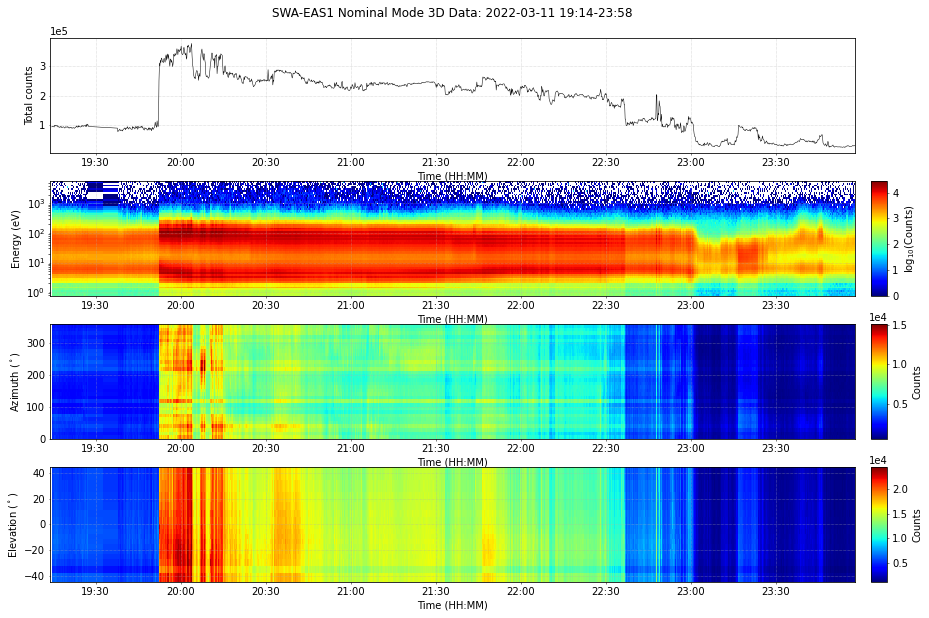

In [6]:
# EAS1
make_plots(fname_1, time_1, counts_tot_1, energy_1, azim_1, elev_1, counts_energy_spectro_1, counts_azim_spectro_1, counts_elev_spectro_1)

/var/folders/z5/q_vgztyd74lcfdrvs_tmx0sh0000gp/T/ipykernel_22200/1272299431.py:31: RuntimeWarning: divide by zero encountered in log10
  CS2 = ax2.pcolormesh(x[:,:], y[:,:], np.log10(counts_energy_spectro[:,:]), cmap='jet') # plot spectrogram


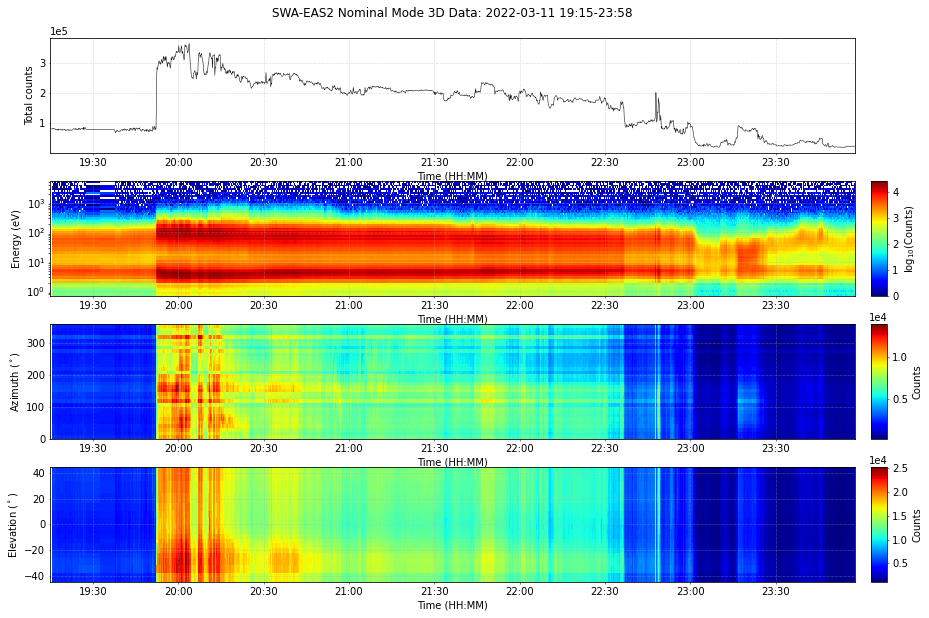

In [7]:
# EAS2
make_plots(fname_2, time_2, counts_tot_2, energy_2, azim_2, elev_2, counts_energy_spectro_2, counts_azim_spectro_2, counts_elev_spectro_2)

[Contents](#Contents)<br>

<a id='Science_data_products'></a>

## 4. Science data products

solo_L2_swa-eas▭-nm3D-▭_▭-▭.cdf

Units:

- $\text{s}^{3}$ $\text{km}^{-6}$ (PSD = phase space density)
- $\text{eV}$ $\text{m}^{-2}$ $\text{s}^{-1}$ $\text{sr}^{-1}$ $\text{eV}^{-1}$ (DEF = differential energy flux)
- $\text{m}^{-2}$ $\text{s}^{-1}$ $\text{sr}^{-1}$ $\text{eV}^{-1}$ (DNF = differential number flux)

**Objective**

Generate spectrograms of phase space density, differential energy flux and differential number flux.

**Import python libraries**

In [8]:
from spacepy import pycdf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

**Locate the data**

Run ONE cell below for required units.

Edit as required.

In [9]:
# Phase space density

# Data directory
datadir = '/Volumes/lacie/data/swa/eas/2022/L2/nm/psd/'
# EAS1 filename
fname_1 = 'solo_L2_swa-eas1-nm3d-psd_20220311T191430-20220311T235810_V01.cdf'
# EAS2 filename
fname_2 = 'solo_L2_swa-eas2-nm3d-psd_20220311T191530-20220311T235810_V01.cdf'

In [10]:
# Differential energy flux

# Data directory
datadir = '/Volumes/lacie/data/swa/eas/2022/L2/nm/def/'
# EAS1 filename
fname_1 = 'solo_L2_swa-eas1-nm3d-def_20220311T191430-20220311T235810_V01.cdf'
# EAS2 filename
fname_2 = 'solo_L2_swa-eas2-nm3d-def_20220311T191530-20220311T235810_V01.cdf'

In [11]:
# Differential number flux

# Data directory
datadir = '/Volumes/lacie/data/swa/eas/2022/L2/nm/dnf/'
# EAS1 filename
fname_1 = 'solo_L2_swa-eas1-nm3d-dnf_20220311T191430-20220311T235810_V01.cdf'
# EAS2 filename
fname_2 = 'solo_L2_swa-eas2-nm3d-dnf_20220311T191530-20220311T235810_V01.cdf'

**Assign variables to the data**

In [12]:
# EAS1
file_1 = pycdf.CDF(datadir+fname_1)
time_1 = file_1['EPOCH'][...]
elev_1 = file_1['SWA_EAS_ELEVATION'][...]
azim_1 = file_1['SWA_EAS_AZIMUTH'][...]
energy_1 = file_1['SWA_EAS1_ENERGY'][...]
if str(fname_1)[22:25] == 'psd':
    data_1 = file_1['SWA_EAS1_Data'][...]
elif str(fname_1)[22:25] == 'def':
    data_1 = file_1['SWA_EAS1_NM3D_DEF_Data'][...]
elif str(fname_1)[22:25] == 'dnf':
    data_1 = file_1['SWA_EAS1_NM3D_DNF_Data'][...]
file_1.close()
    
# EAS2
file_2 = pycdf.CDF(datadir+fname_2)
time_2 = file_2['EPOCH'][...]
elev_2 = file_2['SWA_EAS_ELEVATION'][...]
azim_2 = file_2['SWA_EAS_AZIMUTH'][...]
energy_2 = file_2['SWA_EAS2_ENERGY'][...]
if str(fname_2)[22:25] == 'psd':
    data_2 = file_2['SWA_EAS2_Data'][...]
elif str(fname_2)[22:25] == 'def':
    data_2 = file_2['SWA_EAS2_NM3D_DEF_Data'][...]
elif str(fname_2)[22:25] == 'dnf':
    data_2 = file_2['SWA_EAS2_NM3D_DNF_Data'][...]
file_2.close()

**Process the data**

In [13]:
def sum2d(data, dimA, dimB):
    sum2d_data = np.sum(np.sum(data, axis=dimA), axis=dimB)
    return sum2d_data.T
# Sum over azimuth and elevation:
data_energy_spectro_1 = sum2d(data_1, 3, 1) # EAS1
data_energy_spectro_2 = sum2d(data_2, 3, 1) # EAS2
# Sum over energy and elevtion
data_azim_spectro_1 = sum2d(data_1, 2, 1) # EAS1
data_azim_spectro_2 = sum2d(data_2, 2, 1) # EAS2
# Sum over energy and azimuth
data_elev_spectro_1 = sum2d(data_1, 3, 2) # EAS1
data_elev_spectro_2 = sum2d(data_2, 3, 2) # EAS2

**Make the plots**

In [14]:
def make_plots(fname, time, energy, azim, elev, data_energy_spectro, data_azim_spectro, data_elev_spectro):
    # Set figure size
    fig = plt.figure(figsize=(15,7.5))
    fig.subplots_adjust(hspace=0.25)
    # Set time range
    t1 = datetime.datetime(year=int(fname[26:30]), month=int(fname[30:32]), day=int(fname[32:34]), \
                           hour=int(fname[35:37]), minute=int(fname[37:39])) # set start time
    t2 = datetime.datetime(year=int(fname[42:46]), month=int(fname[46:48]), day=int(fname[48:50]), \
                           hour=int(fname[51:53]), minute=int(fname[53:55])) # set end time
    xfmt = mdates.DateFormatter('%H:%M')
    # Energy spectrogram
    x, y = np.meshgrid(time, energy[1,:])
    ax1 = fig.add_subplot(311)
    CS1 = ax1.pcolormesh(x[:,:], y[:,:], np.log10(data_energy_spectro[:,:]), cmap='jet') # plot spectrogram
    ax1.set_yscale('log')
    ax1.xaxis.set_major_formatter(xfmt)
    ax1.set_xlim(t1, t2)
    ax1.tick_params(labelbottom=True)
    ax1.set_xlabel('Time (HH:MM)')
    ax1.set_ylabel('Energy (eV)')
    ax1.grid(linestyle=':', linewidth=0.5)
    ax1.set_title('SWA-EAS%s Nominal Mode 3D Data: %s %s-%s\n' %(str(fname)[15:16], str(t1)[0:10], str(t1)[11:16], str(t2)[11:16]))
    ax1_divider = make_axes_locatable(ax1)
    ax1.tick_params(width=0.5, length=1.5)
    cax1 = ax1_divider.append_axes('right', size='2%', pad='2%')
    cax1.tick_params(width=0.5, length=1.5)
    cbar1 = plt.colorbar(CS1, cax=cax1, label='$\mathregular{log_{10}}$(%s)' %str(fname)[22:25])
    cbar1.minorticks_off()
    # Azimuth spectrogram
    x, y = np.meshgrid(time, azim)
    ax2 = fig.add_subplot(312)
    CS2 = ax2.pcolormesh(x[:,:], y[:,:], data_azim_spectro[:,:], cmap='jet')
    ax2.xaxis.set_major_formatter(xfmt)
    ax2.set_xlim(t1, t2)
    ax2.tick_params(labelbottom=True)
    ax2.set_xlabel('Time (HH:MM)')
    ax2.set_ylabel('Azimuth ($^\circ$)')
    ax2.grid(linestyle=':', linewidth=0.5)
    ax2_divider = make_axes_locatable(ax2)
    ax2.tick_params(width=0.5, length=1.5)
    cax2 = ax2_divider.append_axes('right', size='2%', pad='2%')
    cax2.tick_params(width=0.5, length=1.5)
    cbar2 = plt.colorbar(CS2, cax=cax2, label='%s' %str(fname)[22:25])
    cbar2.formatter.set_powerlimits((0,0))
    cbar2.minorticks_off()
    # Elevation spectrogram
    x, y = np.meshgrid(time, elev)
    ax3 = fig.add_subplot(313)
    CS3 = ax3.pcolormesh(x[:,:], y[:,:], data_elev_spectro[:,:][::-1], cmap='jet')
    ax3.xaxis.set_major_formatter(xfmt)
    ax3.set_xlim(t1, t2)
    ax3.set_xlabel('Time (HH:MM)')
    ax3.set_ylabel('Elevation ($^\circ$)')
    ax3.grid(linestyle=':', linewidth=0.5)
    ax3_divider = make_axes_locatable(ax3)
    ax3.tick_params(width=0.5, length=1.5)
    cax3 = ax3_divider.append_axes('right', size='2%', pad='2%')
    cax3.tick_params(width=0.5, length=1.5)
    cbar3 = plt.colorbar(CS3, cax=cax3, label='%s' %str(fname)[22:25])
    cbar3.formatter.set_powerlimits((0,0))
    cbar3.minorticks_off()
    return

/var/folders/z5/q_vgztyd74lcfdrvs_tmx0sh0000gp/T/ipykernel_22200/355508993.py:14: RuntimeWarning: divide by zero encountered in log10
  CS1 = ax1.pcolormesh(x[:,:], y[:,:], np.log10(data_energy_spectro[:,:]), cmap='jet') # plot spectrogram


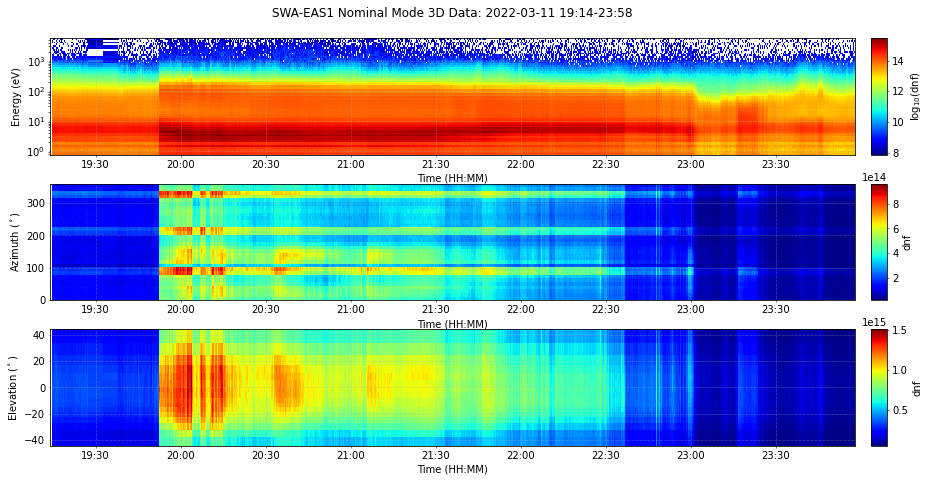

In [15]:
# EAS1
make_plots(fname_1, time_1, energy_1, azim_1, elev_1, data_energy_spectro_1, data_azim_spectro_1, data_elev_spectro_1)

/var/folders/z5/q_vgztyd74lcfdrvs_tmx0sh0000gp/T/ipykernel_22200/355508993.py:14: RuntimeWarning: divide by zero encountered in log10
  CS1 = ax1.pcolormesh(x[:,:], y[:,:], np.log10(data_energy_spectro[:,:]), cmap='jet') # plot spectrogram


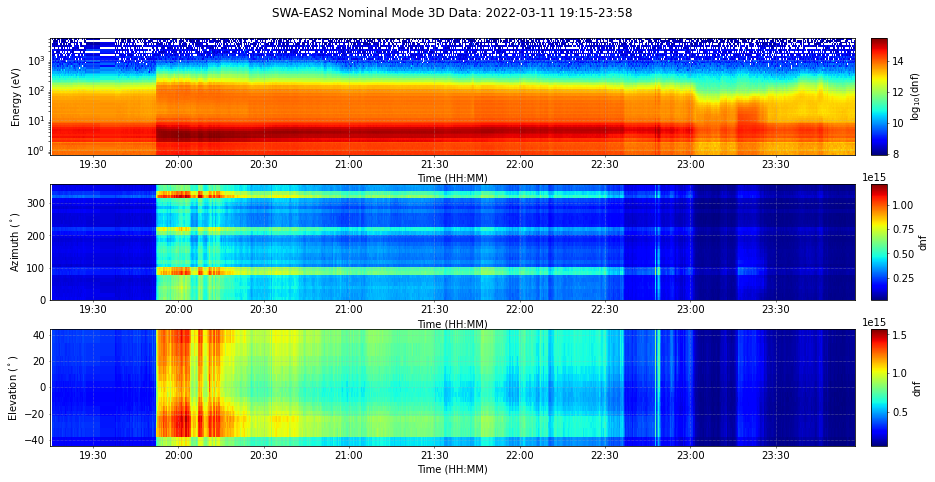

In [16]:
# EAS2
make_plots(fname_2, time_2, energy_2, azim_2, elev_2, data_energy_spectro_2, data_azim_spectro_2, data_elev_spectro_2)

[Contents](#Contents)<br>

<a id='Higher_level_data_products'></a>

## 5. Higher level data products

solo_L3_swa-eas-▭pad-▭_▭-▭.cdf

Units:

- $\text{s}^{3}$ $\text{km}^{-6}$ (PSD = phase space density)
- $\text{eV}$ $\text{m}^{-2}$ $\text{s}^{-1}$ $\text{sr}^{-1}$ $\text{eV}^{-1}$ (DEF = differential energy flux)
- $\text{m}^{-2}$ $\text{s}^{-1}$ $\text{sr}^{-1}$ $\text{eV}^{-1}$ (DNF = differential number flux)

**Objective**

Generate re-binned spectrograms of phase space density, differential energy flux and differential number flux.

**Import python libraries**

In [17]:
from spacepy import pycdf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

**Locate the data**

Edit as required.

In [18]:
# Phase space density

# Data directory
datadir = '/Volumes/lacie/data/swa/eas/2020/L3/bm/pitch_angle/'
# Filename
fname = 'solo_L3_swa-eas-bmpad-psd_20200624T053335-20200624T053834_V01.cdf'

**Assign variables to the data**

In [19]:
file = pycdf.CDF(datadir+fname)
time = file['EPOCH'][...]
data = file['SWA_EAS_BMPAD_PSD_Data'][...]
pitch_angle = file['SWA_EAS_PITCH_ANGLE'][...]
energy = file['SWA_EAS_ENERGY'][...]
file.close()

**Process the data**

In [20]:
# Sum over energy

# Core population (<50 eV)
data_core_energy = np.sum(data[:,34:64,:], axis=1).T

# Halo/strahl population (~70-1000 eV)
data_halostrahl_energy = np.sum(data[:,0:31,:], axis=1).T

**Make the plots**

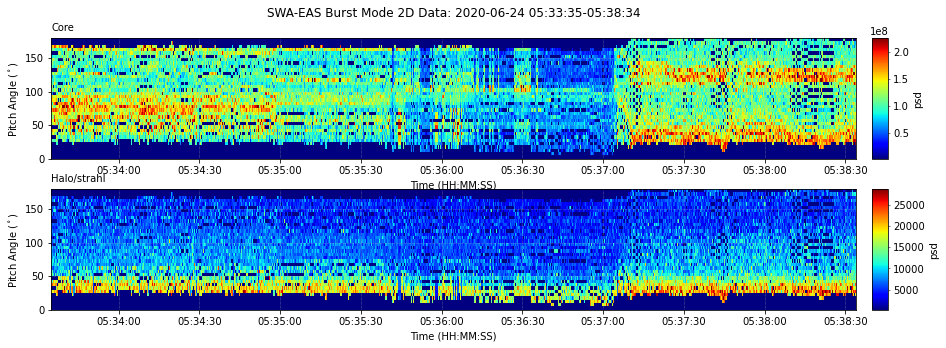

In [21]:
# Set figure size
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.25)
# Set time range
t1 = datetime.datetime(year=int(fname[26:30]), month=int(fname[30:32]), day=int(fname[32:34]), \
                       hour=int(fname[35:37]), minute=int(fname[37:39]), second=int(fname[39:41])) # set start time
t2 = datetime.datetime(year=int(fname[42:46]), month=int(fname[46:48]), day=int(fname[48:50]), \
                       hour=int(fname[51:53]), minute=int(fname[53:55]), second=int(fname[55:57])) # set end time
xfmt = mdates.DateFormatter('%H:%M:%S')
# Core spectrogram
x, y = np.meshgrid(time, pitch_angle[0,:])
ax1 = fig.add_subplot(211)
cb_max = np.nanmax(data_core_energy)/1.5
cb_min = cb_max/100
CS1 = ax1.pcolormesh(x[:,:], y[:,:], data_core_energy[:,:], vmin=cb_min, vmax=cb_max, cmap='jet')
ax1.xaxis.set_major_formatter(xfmt)
ax1.set_xlim(t1, t2)
ax1.set_ylim(0,180)
ax1.set_xlabel('Time (HH:MM:SS)')
ax1.set_ylabel('Pitch Angle ($^\circ$)')
ax1.grid(linestyle=':', linewidth=0.5)
ax1.set_title('SWA-EAS Burst Mode 2D Data: %s %s-%s\n' %(str(t1)[0:10], str(t1)[11:19], str(t2)[11:19]))
ax1.text(t1, 190, 'Core')
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes('right', size='2%', pad='2%')
cax1.tick_params(width=0.5, length=1.5)
cbar1 = plt.colorbar(CS1, cax=cax1, label='%s' %str(fname)[22:25])
cbar1.minorticks_off()
# Halo/strahl spectrogram
x, y = np.meshgrid(time, pitch_angle[0,:])
ax2 = fig.add_subplot(212)
cb_max = np.nanmax(data_halostrahl_energy)/1.5
cb_min = cb_max/100
CS2 = ax2.pcolormesh(x[:,:], y[:,:], data_halostrahl_energy[:,:], vmin=cb_min, vmax=cb_max, cmap='jet')
ax2.xaxis.set_major_formatter(xfmt)
ax2.set_xlim(t1, t2)
ax2.set_ylim(0,180)
ax2.set_xlabel('Time (HH:MM:SS)')
ax2.set_ylabel('Pitch Angle ($^\circ$)')
ax2.grid(linestyle=':', linewidth=0.5)
ax2.text(t1, 190, 'Halo/strahl')
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes('right', size='2%', pad='2%')
cax2.tick_params(width=0.5, length=1.5)
cbar2 = plt.colorbar(CS2, cax=cax2, label='%s' %str(fname)[22:25])
cbar2.minorticks_off()

[Contents](#Contents)<br>

<a id='Further_reading'></a>

## 6. Further reading

- Understanding the data: [SWA Data Product Definition Document (DPDD)](https://issues.cosmos.esa.int/solarorbiterwiki/display/SOSP/Archive+Support+Data#ArchiveSupportData-SWAInstrument)<br>
- Instrument description paper: [Owen et al., A&A (2020)](https://doi.org/10.1051/0004-6361/201937259)
- EAS BM re-binned pitch angle paper: [Owen et al., A&A (2021)](https://doi.org/10.1051/0004-6361/202140959)
<br>

For help with any queries, please contact Dr Chris Kelly (christopher.kelly@ucl.ac.uk) or Dr Gethyn Lewis (g.lewis@ucl.ac.uk).<br>

[Contents](#Contents)<br>